In [22]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
np.set_printoptions(precision=3)

In [23]:
# IBMQ.load_account()

# Grover Search
This file contains the implementation of the Grover Search problem and variations of the algorithm applied to different data structures (quantum walks) and using a different method (QAOA). 

We start out by importing the files containing the functions that will be used to construct the circuits.

The aproach was to create an oracle and a diffusion operator by implementing their respective diagonal matrices and subsequently use qiskit to create an equivalent circuit. We then append the oracle and diffusion operators to the specific data structure in the overarching search function. The only exception to this is the QAOA algorithm, that requires a different methodology due to the nature of the algorithm.

In [24]:
%run groverFuncs.py
%run bipartiteGraphFuncs.py
%run completeGraphFuncs.py

## Generalized Grover
In this section we implement the generalized version of the grover algorith.  
The **oracle** has the following effect in a generic state

<img src="Images/oracleGrover.png" />

And it corresponds to the following diagonal matrix if we were to search for state |1> in an N=2 qubit system 

In [25]:
print(getOracle([1],2))

[[ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


The **diffusion operator** is given by

<img src="Images/diffGrover.png"/>

where |$\psi$> is the balanced superposition of the system's states.  
The matrix corresponding to this operator is 

In [26]:
print(simulUnitary(diffusionGrover(2)))

[[ 0.5-1.225e-16j -0.5+1.225e-16j -0.5+1.225e-16j -0.5+1.225e-16j]
 [-0.5+6.123e-17j  0.5-1.837e-16j -0.5+6.123e-17j -0.5+1.837e-16j]
 [-0.5+6.123e-17j -0.5+6.123e-17j  0.5-1.837e-16j -0.5+1.837e-16j]
 [-0.5+0.000e+00j -0.5+1.225e-16j -0.5+1.225e-16j  0.5-2.449e-16j]]


The entire circuit will then be the successive application of both of these operators.  
The circuit after one step is then

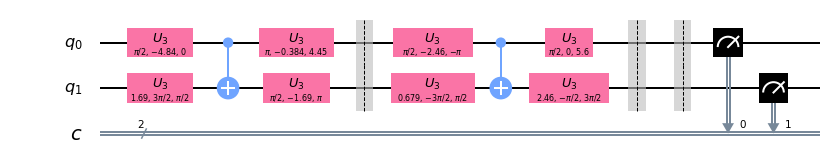

In [27]:
grover2([0],2,1).draw(output='mpl')

## Grover Search in a Complete Graph

Implementing the Grover Search in a Complete Graph relies on the fact that the "classical" Grover's algorithm is equivalent to searching a Complete Graph with loops, as was shown in Renato Portugal's book "Quantum Walks and Search Algorithms".  

The first step in this implementation was noticing that the shift operator is defined as

<img src="Images/shiftRenato.png"/>

Inspired by B. L. Dougas and J. B. Wang's article "Efficient quantum circuit implementation of quantum walks" we placed a series of swap gates between the register qubits (vertices) and the coin 

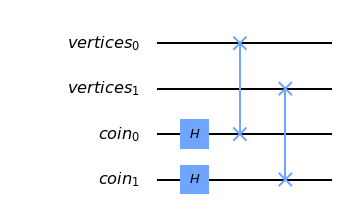

In [28]:
completeGraphWalk2(2).draw(output='mpl')

The coin operator wont be the Hadamard operator however, it will be given by

<img src="Images/coinCompleteRenato.png"/>

Where G is the diffusion operator defined above.  
The oracle operator will be the same as the Grover Algorithm, applied only to the vertices.

The entire circuit will be


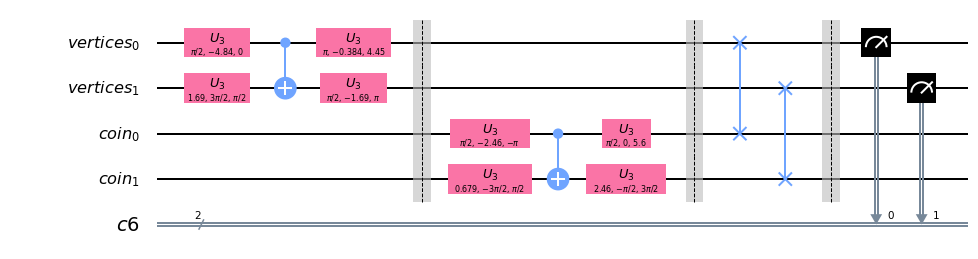

In [29]:
runWalkComplete2([0],2,1).draw(output='mpl')

Note that the function allows for an arbitrary number of vertices and coin states as well as the ability to mark any number of elements, at the cost of a bigger circuit size which means more error outside of the simulator.

## Bipartite Graph

Searching through a bipartite graph is very similar to the complete graph case, the difference being the structure of the graph

<img src="Images/bipartitegraph.png" alt="Drawing" style="width: 300px;"/>

We can tell from the image that this graph can be viewed as a complete graph (all edges connected) where each vertex had one edge removed.  
Translating into a circuit, this corresponds to removing one qubit of the coin operator and replacing the swap of the most significant qubit with an X gate


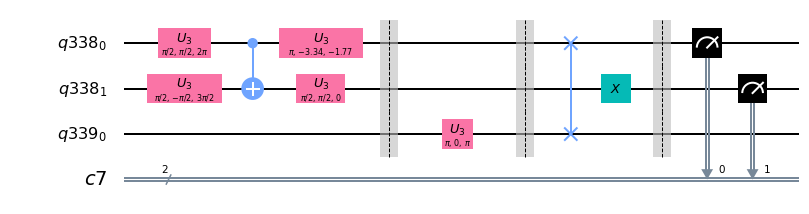

In [30]:
runWalkBipartite2([0],2,1,1).draw(output='mpl')

## Results

### QASM

In [31]:
# plot_histogram(simul(qcB))
# plot_histogram(simul(qcC))
# plot_histogram(simul(qcG))

In [32]:
# plot_histogram([simul(qcG),simul(qcB),simul(qcC)],legend=['Grover', 'Bipartite','Complete'],bar_labels=True)
# plot_histogram([simul(qcG),simul(qcC),simul(qcB)],legend=['Grover', 'Complete','Bipartite'],bar_labels=False)